In [1]:
import sqlite3
import pickle
import pandas as pd

In [2]:
conn = sqlite3.connect('../twitoff/twitoff.sqlite')

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [4]:
query = '''
SELECT 
  tweet.id,
  tweet.text,
  tweet.embedding,
  user.username
FROM tweet
JOIN user ON tweet.user_id = user.id;
'''

df = get_data(query, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x[2:]))
print(df.shape)
df.head()

(532, 5)


,id,text,embedding,username,embedding_decoded
0,1294101630871384071,Degree of difficulty off the charts. 🤯\n\n📺: @...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,nba,"[-0.459334, -0.403374, 1.00874, -0.186087, 1.5..."
1,1294097604201132038,The @trailblazers lead the @BrooklynNets 73-67...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,nba,"[-0.202672, -0.143187, 0.506858, -0.555718, 0...."
2,1294096288808685574,🔥 @trailblazers backcourt with 35 PTS and 11 A...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,nba,"[-0.577384, -0.452478, 0.250774, -0.262425, 0...."
3,1294093313230938112,CJ gets to his spot for the PURE jumper.\n\n#W...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,nba,"[-0.392507, -0.320284, 0.780428, -0.154092, 0...."
4,1294092657640210434,Back-to-back ABSURD threes for Dame...😳 https:...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,nba,"[-0.591236, -0.193994, 0.592527, -0.714257, 0...."


In [5]:
df.username.value_counts()

jeffbezos    185
nasa         129
nba          127
macjabeth     59
elonmusk      22
walmart       10
Name: username, dtype: int64

In [6]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username=='elonmusk']
user2_embeddings = df.embedding_decoded[df.username=='nasa']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.tolist(),
                             columns=[f'dim{i}' for i in range(768)])
labels = np.concatenate([np.ones(len(user1_embeddings)), 
                         np.zeros(len(user2_embeddings))])
print(embeddings_df.shape, labels.shape)

(151, 768) (151,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape)

(113, 768) (38, 768)


In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        32
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



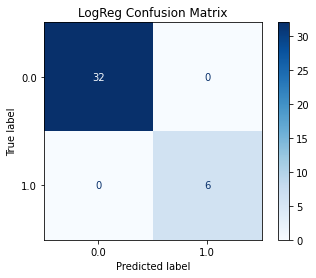

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues')
plt.title('LogReg Confusion Matrix');

In [11]:
pickle.dump(lr, open("../models/logreg.pkl", "wb"))

In [12]:
lr_unpickled = pickle.load(open("../models/logreg.pkl", "rb"))
lr_unpickled

LogisticRegression(max_iter=1000)

In [13]:
import basilica

BASILICA_KEY='475acaa5-8aa3-f9a2-d30d-4bea3b11addd'
BASILICA = basilica.Connection(BASILICA_KEY)

In [14]:
example_embedding = BASILICA.embed_sentence('The MARS rover just reported new and interesting data!', model='twitter')

In [15]:
lr_unpickled.predict([example_embedding])[0]

1.0